In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
from sklearn.utils import shuffle
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
from tensorflow.keras.applications import VGG16, ResNet152
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


In [2]:
os.getcwd()

'c:\\Users\\thoma\\Desktop\\speciale\\DeepLearning_Master\\models\\shallow'

In [3]:
train_path = "../../Data/Windows_01/train"
batch_size = 32
resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)
os.getcwd()

'c:\\Users\\thoma\\Desktop\\speciale\\DeepLearning_Master\\models\\shallow'

In [4]:
# import os
# path = '/Users/myName/Desktop/directory'

# count = 0
# for folder in os.listdir(train_path):
#     print(folder)
#     for file in os.listdir(train_path + "/" + folder):
#         print(file)
#         print(len(file))
#         if(len(file)> 25):
#             try:
#                 x = file[:-10] + ".png"
#                 os.rename(train_path + "/" + folder + "/" + file, train_path + "/" + folder + "/" + x)
#                 os.remove(train_path + "/" + folder + "/" + file)
#             except:
#                 pass
#         print(x)

In [4]:
os.remove(train_path + "/.DS_Store")

FileNotFoundError: [WinError 2] Den angivne fil blev ikke fundet: '../../Data/Windows_01/train/.DS_Store'

In [4]:
for f in os.listdir(train_path):
    print(f)

Interictal
Preictal
Seizure


In [5]:
labels = [item for item in os.listdir(train_path)]
labels

['Interictal', 'Preictal', 'Seizure']

In [6]:
def inspect_class_distribution():
    dist_list = {}
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        #dict = {classname, number_of_png}
        dist_list[classname] =  number_of_png
    return dist_list

inspect_class_distribution()

{'Interictal': '38919', 'Preictal': '9537', 'Seizure': '6963'}

In [12]:
max_n_images = int(inspect_class_distribution().get('Seizure'))

In [7]:
myList = random.sample(range(1, 100),100-1)

# taking an input list
l1 = []
  
# taking an counter
count = 0
  
# travesing the array
for item in myList:
    if item not in l1:
        count += 1
        l1.append(item)
  
# printing the output
print("No of unique items are:", count)

No of unique items are: 99


In [13]:
path_list = random.sample(os.listdir(train_path + "/Interictal"), 2)

In [14]:
def limit_data(data_dir,n=max_n_images):
    a=[]
    for i in os.listdir(data_dir):
        image_path = random.sample(os.listdir(data_dir+'/'+i), max_n_images)
        for k,j in enumerate(image_path):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class'])

In [15]:
balanced_data = limit_data(train_path)

In [17]:
balanced_data.head()

,filename,class
9812,../../Data/Windows_01/train/Preictal/chb20_16_...,Preictal
7328,../../Data/Windows_01/train/Preictal/chb20_13_...,Preictal
8068,../../Data/Windows_01/train/Preictal/chb22_20_...,Preictal
2925,../../Data/Windows_01/train/Interictal/chb01_2...,Interictal
17386,../../Data/Windows_01/train/Seizure/chb03_36_1...,Seizure


In [16]:
balanced_data = shuffle(balanced_data)

In [18]:
print(balanced_data['class'].nunique())
balanced_data['filename'].nunique()

3


20889

In [21]:
vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape = (299, 299, 3)
)

for layer in vgg16.layers:
    layer.trainable = True

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [22]:
model = Sequential()

model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [18]:
# model = Sequential()

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), input_shape=(299,299,3)))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3)))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Conv2D(128, (3, 3)))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3)))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(3, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [20]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [21]:
generator = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  validation_split=0.3,
  zoom_range=0.2
)

In [22]:
train_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=inceptionV3_input_shape, 
    shuffle=True,
    subset="training")

Found 14623 validated image filenames belonging to 3 classes.


In [23]:
validation_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=inceptionV3_input_shape, 
    shuffle=False,
    subset="validation")

Found 6266 validated image filenames belonging to 3 classes.


In [24]:
validation_gen.classes

[1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 0,


In [25]:
x = 120
train_gen.classes[x:x+10]

[0, 1, 1, 0, 2, 0, 2, 1, 0, 1]

In [26]:
class_weights = {0: 0.4469741480611046,
                1: 1.0266531713900136,
                2: 1.5509683995922527,
                3: 6.947488584474886}

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(299,299,3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout())
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(4, activation='softmax'))

In [28]:
model = tensorflow.keras.models.load_model("vgg_cnn.h5")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [29]:
from tensorflow.keras.optimizers import Adam, SGD
opt = Adam(0.00001)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=['accuracy']
)

In [28]:
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [29]:
# lr_finder = LRFinder(min_lr=1e-5, 
#                     max_lr=1e-2, 
#                     steps_per_epoch=np.ceil(5/batch_size), 
#                     epochs=3)

In [30]:
def inspect_class_distribution():
    dist_list = []
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        dict = {classname, number_of_png}
        dist_list.append(dict)
    return dist_list

inspect_class_distribution()

[{'38919', 'Interictal'}, {'9537', 'Preictal'}, {'6963', 'Seizure'}]

In [30]:
history = model.fit(
    train_gen,
    epochs=10,
    steps_per_epoch = train_gen.samples//batch_size, 
    validation_data=validation_gen, 
    validation_steps = validation_gen.samples//batch_size,
    #callbacks=[lr_finder]
    #class_weight=class_weights
    
)

Epoch 1/10
456/456 [==============================] - 663s 1s/step - loss: 0.5478 - accuracy: 0.7074 - val_loss: 0.5272 - val_accuracy: 0.7321
Epoch 2/10
456/456 [==============================] - 610s 1s/step - loss: 0.5161 - accuracy: 0.7244 - val_loss: 0.5234 - val_accuracy: 0.7276
Epoch 3/10
456/456 [==============================] - 631s 1s/step - loss: 0.4968 - accuracy: 0.7377 - val_loss: 0.5155 - val_accuracy: 0.7234
Epoch 4/10
456/456 [==============================] - 684s 1s/step - loss: 0.4860 - accuracy: 0.7459 - val_loss: 0.5225 - val_accuracy: 0.7279
Epoch 5/10
456/456 [==============================] - 728s 2s/step - loss: 0.4638 - accuracy: 0.7572 - val_loss: 0.5513 - val_accuracy: 0.7271
Epoch 6/10
456/456 [==============================] - 726s 2s/step - loss: 0.4433 - accuracy: 0.7681 - val_loss: 0.5651 - val_accuracy: 0.7212
Epoch 7/10
456/456 [==============================] - 712s 2s/step - loss: 0.4314 - accuracy: 0.7773 - val_loss: 0.5147 - val_accuracy: 0.7274

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(train_path).rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
#lr_finder.plot_loss()

In [44]:
model.save("vgg_cnn2.h5")

In [ ]:
with open('history.txt', 'w') as f:
    f.write(str(history.history))

<Figure size 216x288 with 0 Axes>

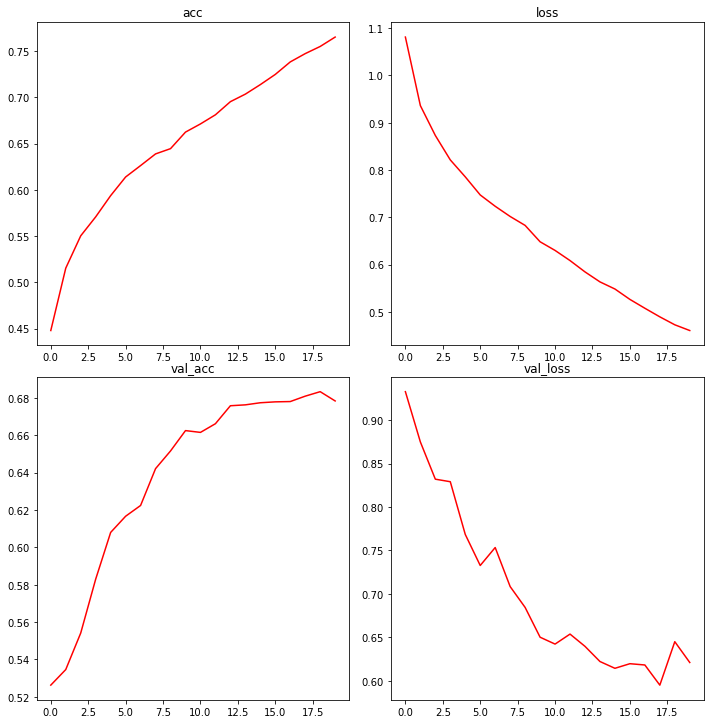

In [39]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
#plt.savefig("eval.png")

<Figure size 216x288 with 0 Axes>

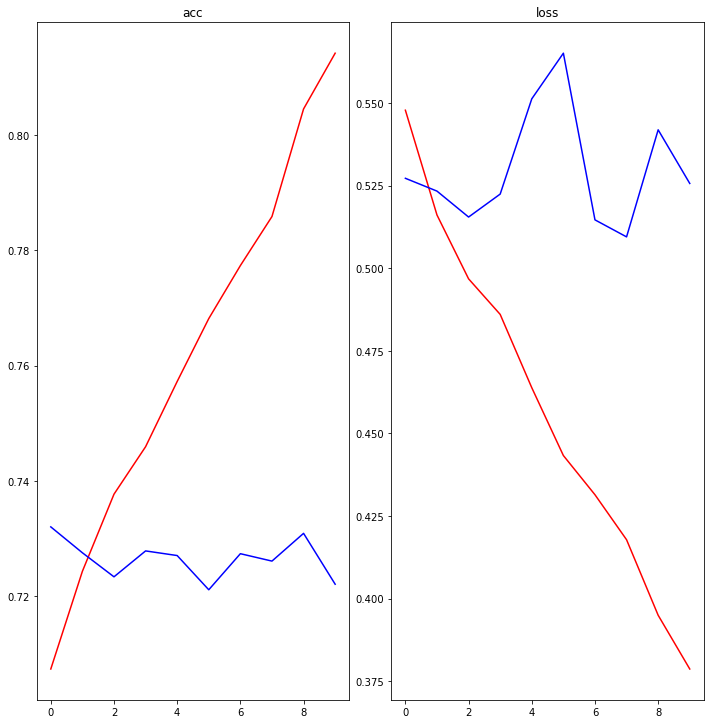

In [31]:
plt.figure(figsize=(3,4))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
plt.tight_layout()
ax1.set_title('acc')
ax1.plot(history.history['accuracy'], color='red')
ax1.plot(history.history['val_accuracy'], color='blue')

ax2.set_title('loss')
ax2.plot(history.history['loss'], color='red')
ax2.plot(history.history['val_loss'], color='blue')

In [32]:
test_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=1, 
    target_size=inceptionV3_input_shape, 
    shuffle=True,
 #   class_mode="binary",
    subset="validation")

Found 6266 validated image filenames belonging to 3 classes.


In [33]:
number_of_step = test_gen.samples // 1
number_of_step

6266

In [34]:
pred = model.predict(test_gen, steps=number_of_step)

In [35]:
y_pred_max = pred.argmax(axis=-1)

In [36]:
y_true = test_gen.classes

In [37]:
for i, x in enumerate(test_gen.classes[0:6]):
    filename = test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

index : 0, y_true : 1 : filename : ../../Data/Windows_01/train/Preictal/chb20_16_62_F3-C3_08-29-46.png
index : 1, y_true : 1 : filename : ../../Data/Windows_01/train/Preictal/chb20_13_157_F3-C3_05-34-48.png
index : 2, y_true : 1 : filename : ../../Data/Windows_01/train/Preictal/chb22_20_44_F3-C3_18-33-30.png
index : 3, y_true : 0 : filename : ../../Data/Windows_01/train/Interictal/chb01_26_121_F3-C3_13-11-13.png
index : 4, y_true : 2 : filename : ../../Data/Windows_01/train/Seizure/chb03_36_1_F3-C3_05-20-31.png
index : 5, y_true : 1 : filename : ../../Data/Windows_01/train/Preictal/chb01_26_1_F3-C3_12-50-34.png


In [38]:
labels = ['Interictal', 'Preictal', 'Seizure']

In [39]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

In [40]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [41]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.35      0.44      0.39      2150
    Preictal       0.34      0.26      0.29      2067
     Seizure       0.34      0.34      0.34      2049

    accuracy                           0.35      6266
   macro avg       0.35      0.35      0.34      6266
weighted avg       0.35      0.35      0.34      6266



In [42]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max))

confusion_matrix

array([[947, 532, 671],
       [878, 532, 657],
       [870, 481, 698]], dtype=int64)

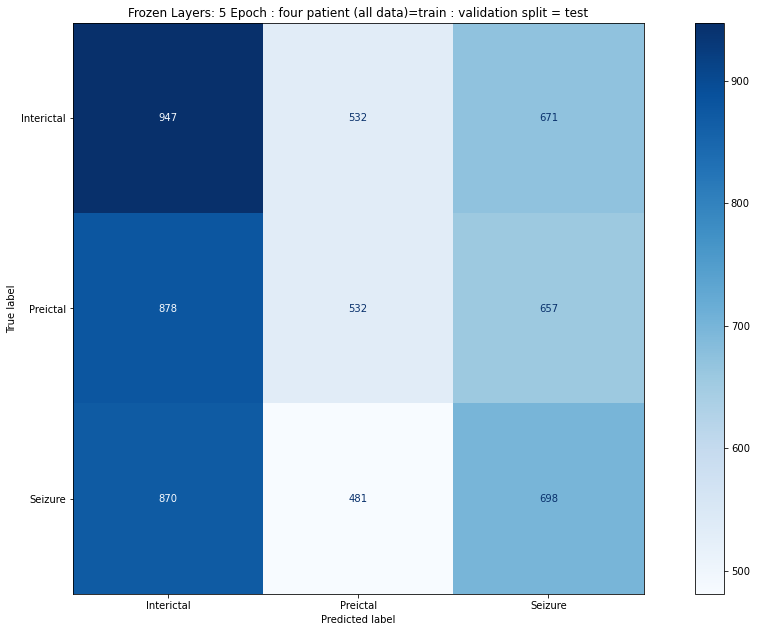

In [43]:
import matplotlib
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("resnet_only_sz_cb07_test.png")